In [2]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy
import random
import os
import matplotlib as mpl
import matplotlib.tri as tri
import ternary
import pickle
import datetime
from collections import Counter
import matplotlib.ticker as ticker
import pyDOE
import random
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import decomposition
import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.font_manager as font_manager
import copy

In [1]:
# random state for PCA
rs = 0

# Load dataset

In [3]:
# go to directory where datasets reside
# load a dataset
# dataset names = ['Crossed barrel', 'Perovskite', 'AgNP', 'P3HT', 'AutoAM']
dataset_name = 'Crossed barrel'
raw_dataset = pd.read_csv('datasets/' + dataset_name + '_dataset.csv')
feature_name = list(raw_dataset.columns)[:-1]
objective_name = list(raw_dataset.columns)[-1]

# Formulate optimization as global minimization

In [4]:
ds = copy.deepcopy(raw_dataset) 
# only P3HT/CNT, Crossed barrel, AutoAM need this line; Perovskite and AgNP do not need this line.
ds[objective_name] = -raw_dataset[objective_name].values

# Process dataset for pool-based active learning

In [5]:
ds_grouped = ds.groupby(feature_name)[objective_name].agg(lambda x: x.unique().mean())
ds_grouped = (ds_grouped.to_frame()).reset_index()
ds_grouped

,n,theta,r,t,toughness
0,6,0,1.5,0.70,-1.135453
1,6,0,1.5,1.05,-1.406492
2,6,0,1.5,1.40,-1.343498
3,6,0,1.7,0.70,-3.102525
4,6,0,1.7,1.05,-3.196597
...,...,...,...,...,...
595,12,200,2.3,1.05,-4.775444
596,12,200,2.3,1.40,-1.997221
597,12,200,2.5,0.70,-24.956734
598,12,200,2.5,1.05,-1.360121


# Normalize input features and objective values

In [6]:
s_scaler = preprocessing.StandardScaler()
ds_normalized_values = s_scaler.fit_transform(ds_grouped[list(raw_dataset.columns)].values)
ds_normalized = pd.DataFrame(ds_normalized_values, columns = list(raw_dataset.columns))
ds_normalized

,n,theta,r,t,toughness
0,-1.341641,-1.53393,-1.565561,-1.224745,1.310884
1,-1.341641,-1.53393,-1.565561,0.000000,1.285839
2,-1.341641,-1.53393,-1.565561,1.224745,1.291659
3,-1.341641,-1.53393,-0.939336,-1.224745,1.129119
4,-1.341641,-1.53393,-0.939336,0.000000,1.120426
...,...,...,...,...,...
595,1.341641,1.53393,0.939336,0.000000,0.974535
596,1.341641,1.53393,0.939336,1.224745,1.231253
597,1.341641,1.53393,1.565561,-1.224745,-0.890291
598,1.341641,1.53393,1.565561,0.000000,1.290123


# Histogram of objective values

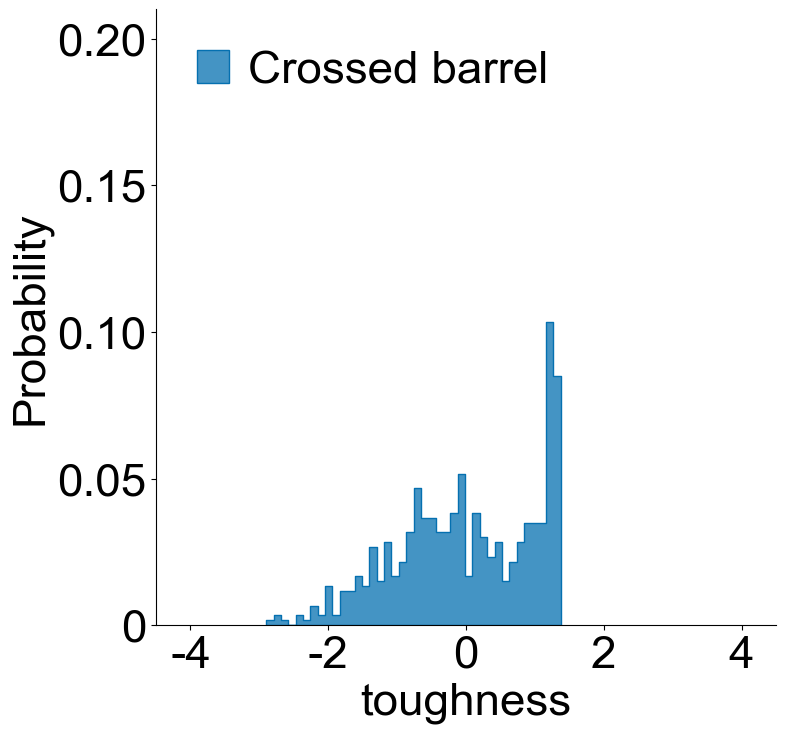

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(ds_normalized[objective_name], stat="probability", discrete=False, bins = 40, element = 'step', color = '#0570b0')
ax.set_xlim([-4.5, 4.5])
ax.set_ylim([0, 0.21])

ax.set_ylabel('Probability', fontsize=33, fontname="Arial")
ax.set_xlabel(objective_name, fontsize=33, fontname="Arial")

ax.xaxis.set_tick_params(labelsize=33)
plt.xticks([-4, -2, 0, 2, 4], ['-4', '-2', '0', '2', '4'],fontname = 'Arial')

plt.yticks([0, 0.05, 0.1, 0.15, 0.2], ['0', '0.05', '0.10', '0.15', '0.20'], fontname = 'Arial')
ax.yaxis.set_tick_params(labelsize=33)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

font = font_manager.FontProperties(family='Arial',
                                   size = 33,
                                   style='normal')
leg = plt.legend(labels=[dataset_name], handlelength = 0.7, handletextpad = 0.4, prop = font, frameon=False, loc = 'upper left')



# Perform PCA

In [8]:
# since the five datasets have different dimensions, we want to visualize their manifold in a consistent manner
# here we want to visualize the pool of candidates in their respective 3D principal component space
pca_ = decomposition.PCA(n_components=3, random_state = rs)
pca_.fit(ds_normalized[feature_name])
X_pca_values = pca_.transform(ds_normalized[feature_name])


In [9]:
print(X_pca_values.shape)

(600, 3)


In [10]:
# Percentage of variance explained by each of the selected components
# i.e. eigenvalues of each principal component
print(pca_.explained_variance_ratio_)

[0.25 0.25 0.25]


In [11]:
X_pca = pd.DataFrame()
X_pca['PC1'] = X_pca_values[:,0] 
X_pca['PC2'] = X_pca_values[:,1] 
X_pca['PC3'] = X_pca_values[:,2] 
X_pca[objective_name] = ds_normalized[objective_name]

In [12]:
X_pca

,PC1,PC2,PC3,toughness
0,1.341641,-0.408220,0.997825,1.310884
1,1.341641,-1.189643,0.160389,1.285839
2,1.341641,-1.971066,-0.677047,1.291659
3,1.341641,-0.404809,1.283284,1.129119
4,1.341641,-1.186232,0.445848,1.120426
...,...,...,...,...
595,-1.341641,1.186232,-0.445848,0.974535
596,-1.341641,0.404809,-1.283284,1.231253
597,-1.341641,1.971066,0.677047,-0.890291
598,-1.341641,1.189643,-0.160389,1.290123


# Visualize in 3D 

In [13]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color= objective_name, size_max = 20, opacity = 0.6)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_layout(
    autosize = False,
    scene = dict(
        xaxis = dict(autorange=False, 
                     nticks=3, 
                     range=[-2.5,4],
                     backgroundcolor="rgb(215, 200,215)",
                     gridcolor="white",
                     gridwidth = 2,
                     linecolor = "rgb(255, 255, 255)",
                     linewidth = 10,
                     showbackground=True,
                     zerolinecolor="rgb(255, 255, 255)",
                     zeroline = True,
                     zerolinewidth = 10,
                     showgrid = True,
                     visible = True,
                     showticklabels = False),
        yaxis = dict(autorange=False, 
                     nticks=3, 
                     range=[-2.4,5],
                     backgroundcolor="rgb(215, 200,215)",
                     gridcolor="white",
                     gridwidth = 2,
                     linecolor = "rgb(255, 255, 255)",
                     linewidth = 10,
                     showbackground=True,
                     zerolinecolor="rgb(255, 255, 255)",
                     zeroline = True,
                     zerolinewidth = 10,
                     showgrid = True,
                     visible = True,
                     showticklabels = False),
        zaxis = dict(autorange=False, 
                     nticks=3, 
                     range=[-3,4.5],
                     backgroundcolor="rgb(215, 200,215)",
                     gridcolor="white",
                     gridwidth = 2,
                     linecolor = "rgb(255, 255, 255)",
                     linewidth = 10,
                     showbackground=True,
                     zerolinecolor="rgb(255, 255, 255)",
                     zeroline = True,
                     zerolinewidth = 10,
                     showgrid = True,
                     visible = True,
                     showticklabels = False)
                ),
    
    scene_camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-1.2, y=1.56, z=1.92))
)







fig.update_layout(width=700, height=700, plot_bgcolor='rgb(0,0,0)')

fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1))

fig.update_layout(title = dict(text=dataset_name,
                               x=0.5,
                               y=0.95),
                               font=dict(family="Arial", size=20))

fig.update_layout(font=dict(family="Arial", size=20))


fig.show()
